# Bacteria Colony Classification

Import the necessary packages

In [1]:
import numpy as np
import pandas as pd
import keras as keras
import scipy.misc
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from keras import applications
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout, Flatten, Lambda, Dense, Activation
from keras.models import Model, Sequential
from keras.utils import np_utils, to_categorical
from keras.preprocessing import image    
from matplotlib import pyplot
from scipy.misc import toimage
from glob import glob
from PIL import Image
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import cv2
import random

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Import the images and the labels into a list. Note, we have 33 categories of images of total number images equal to 689.

Images can be downloaded from here: http://misztal.edu.pl/software/databases/dibas/

In [2]:
dirs = os.listdir("Bacteria")
print(len(dirs))

33


In [3]:
image_list = []
index_list = []
img_size=500
no_of_labels=len(dirs)
for i in range(no_of_labels):
    for filename in glob("Bacteria/"+dirs[i]+"/*.tif"):
        img = cv2.imread(filename)
        img = np.array(img, np.float32)
        img = scipy.misc.imresize(img, (img_size, img_size))
        image_list.append(img)
        index_list.append(i)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


Shuffle the images

In [4]:
c = list(zip(image_list, index_list))

random.shuffle(c)

image_list, index_list = zip(*c)

In [5]:
print(len(image_list))
print(len(index_list))
print(index_list[:5])

689
689
(22, 27, 9, 0, 1)


Lets see what the images look like

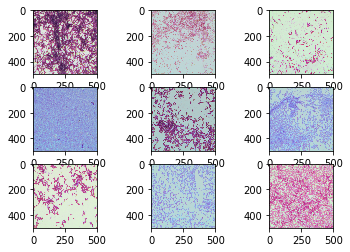

In [6]:
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(image_list[i])
pyplot.show()


Divide the images into train and test set. Also normalization is done here by dividing by 255.

In [7]:
total_size=len(image_list)
train_size=int(0.85*total_size)
train_images=image_list[:train_size]
val_images=image_list[train_size:]
print(len(train_images))
print(len(val_images))
train_images=np.array(train_images)/255
val_images=np.array(val_images)/255
print(train_images.shape)
print(val_images.shape)
#train_images = train_images.reshape(train_images.shape[0], img_size, img_size, 1)
#val_images = val_images.reshape(val_images.shape[0], img_size, img_size, 1)

585
104
(585, 500, 500, 3)
(104, 500, 500, 3)


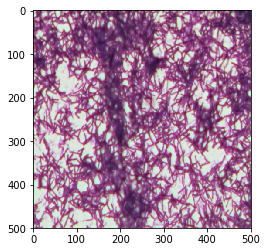

In [8]:
pyplot.imshow(train_images[0])

Convert the labels to categorical form

In [11]:
train_labels=to_categorical(index_list[:train_size], num_classes=no_of_labels)
val_labels=to_categorical(index_list[train_size:], num_classes=no_of_labels)

In [12]:
print(train_images.shape)
print(train_labels.shape)
print(val_images.shape)
print(val_labels.shape)

(585, 500, 500, 3)
(585, 33)
(104, 500, 500, 3)
(104, 33)


The convolutional model for classification of images is created here. 

The primary motive here was to create a network with a small number of parameters. This is necessary to prevent overfitting since we have a very small training set. 

Note: The flatten layer is what affects the number of parameters the most. Hence the layer before it needs to have a smaller output size.

In [21]:

input_shape = (img_size, img_size,3)
model = Sequential()
model.add(Conv2D(32, kernel_size=(2, 2),activation='relu',
                 input_shape=input_shape,kernel_initializer='glorot_uniform',padding='SAME'))

model.add(Conv2D(16, (2, 2), activation='relu',kernel_initializer='glorot_uniform',padding='SAME'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(8, (2, 2), activation='relu',kernel_initializer='glorot_uniform',padding='SAME'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(4, (3, 3), activation='relu',kernel_initializer='glorot_uniform',padding='SAME'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128,activation='relu',kernel_initializer='glorot_uniform'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu',kernel_initializer='glorot_uniform'))
model.add(Dropout(0.5))
model.add(Dense(no_of_labels, activation='softmax',kernel_initializer='glorot_uniform'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 500, 500, 32)      416       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 500, 500, 16)      2064      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 166, 166, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 166, 166, 8)       520       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 55, 55, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 55, 55, 4)         292       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 27, 27, 4)         0         
__________

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Here the model is fit onto the training set using image augmentation. This greatly improves the final model parameters, though makes the training painfully slow. This piece of code was run atleast 3 times for the final converged paramter values, making the total no. of epochs to 90.

Note: The code was run on GPUs on Amazon AWS EC2.

In [66]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 20

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rotation_range=30,
        zoom_range=0.4,
        width_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True, validation_split=0.15)

train_datagen.fit(train_images)



# fits the model on batches with real-time data augmentation:
model.fit_generator(train_datagen.flow(train_images, train_labels, batch_size=20), 
                    steps_per_epoch=len(train_images) / 20, epochs=30)

Epoch 1/30
30/29 [==============================] - 32s 1s/step - loss: 1.2218 - acc: 0.5400
Epoch 2/30
30/29 [==============================] - 32s 1s/step - loss: 1.2825 - acc: 0.5136
Epoch 3/30
30/29 [==============================] - 32s 1s/step - loss: 1.3418 - acc: 0.5418
Epoch 4/30
30/29 [==============================] - 32s 1s/step - loss: 1.2238 - acc: 0.5268
Epoch 5/30
30/29 [==============================] - 32s 1s/step - loss: 1.2616 - acc: 0.5234
Epoch 6/30
30/29 [==============================] - 32s 1s/step - loss: 1.2369 - acc: 0.5400
Epoch 7/30
30/29 [==============================] - 32s 1s/step - loss: 1.2740 - acc: 0.5284
Epoch 8/30
30/29 [==============================] - 32s 1s/step - loss: 1.2003 - acc: 0.5466
Epoch 9/30
30/29 [==============================] - 32s 1s/step - loss: 1.3788 - acc: 0.4867
Epoch 10/30
30/29 [==============================] - 33s 1s/step - loss: 1.2563 - acc: 0.5466
Epoch 11/30
30/29 [==============================] - 32s 1s/step - lo

Lets see how the model performs on the test data. Note, there is no augmentation of images here.

In [69]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
pred_labels = model.predict(val_images)
y_test_class = np.argmax(val_labels,axis=1)
y_pred_class = np.argmax(pred_labels,axis=1)

accuracy = accuracy_score(y_test_class, y_pred_class)
print(accuracy)

0.6730769230769231


In [70]:
print(classification_report(y_test_class,y_pred_class))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.00      0.00      0.00         2
          2       0.00      0.00      0.00         2
          3       1.00      0.50      0.67         4
          4       1.00      0.60      0.75         5
          5       0.62      0.83      0.71         6
          6       0.00      0.00      0.00         5
          7       0.44      1.00      0.62         4
          8       0.67      0.67      0.67         6
          9       0.67      0.67      0.67         3
         10       1.00      0.67      0.80         3
         11       1.00      1.00      1.00         1
         12       0.80      1.00      0.89         4
         13       1.00      0.67      0.80         3
         14       0.50      1.00      0.67         2
         15       0.67      1.00      0.80         2
         16       1.00      1.00      1.00         5
         17       0.83      1.00      0.91   

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


As observed the model has about 67% accuracy on the test set. Also its average precision, recall and F-1 score is between 65% to 70%. Hence the model performs fairly well even thought the training set is small. This is primarily due image augmentation.